Initial script for testing basic functionality of EfficientNet on smaller data subset, also includes hyperparameter tuning on the full data: a grid-search for learning rate and batch size

## 1. Imports and setup

In [29]:
%%capture
#@title
!pip install tensorflow_addons

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientnetv2" not in os.getcwd():
    !git clone --depth 1 https://github.com/google/automl
    os.chdir('automl/efficientnetv2')
    sys.path.append('.')
else:
    !git pull

def download(m):
    if m not in os.listdir():
        !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
        !tar zxf {m}.tgz
    ckpt_path = os.path.join(os.getcwd(), m)
    return ckpt_path

In [30]:
import tensorflow_hub as hub
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
import csv

## 2. WikiArt Data

In [31]:
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

### Parameters

In [32]:
data_dir_train = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_small/wikipaintings_train'
data_dir_val = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_small/wikipaintings_val'
data_dir_test = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_small/wikipaintings_test'

batch_size =  4   #@param {type:"integer"}
image_size = 223

### Load data into data generator objects

### Load data function

In [33]:
def load_wikidata(train_path, val_path, test_path, batch_size = 4, image_size = 223):
    print("Loading data...")
    print()
    datagen_kwargs = dict(rescale=1./255)
    dataflow_kwargs = dict(target_size=(image_size, image_size),batch_size=batch_size, interpolation="bilinear")
    
    valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
    valid_generator = valid_datagen.flow_from_directory(val_path, shuffle=False, **dataflow_kwargs)
    
    train_datagen = valid_datagen
    train_generator = train_datagen.flow_from_directory(train_path, shuffle=True, **dataflow_kwargs)
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(test_path, shuffle=False, **dataflow_kwargs)
    
    label_map = (train_generator.class_indices)
    print("Label map:")
    print(label_map)
    
    return train_generator, valid_generator, test_generator

In [34]:
train_generator, valid_generator, test_generator = load_wikidata(data_dir_train, data_dir_val, data_dir_test)

Loading data...

Found 250 images belonging to 25 classes.
Found 250 images belonging to 25 classes.
Found 250 images belonging to 25 classes.
Label map:
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Cubism': 6, 'Early_Renaissance': 7, 'Expressionism': 8, 'High_Renaissance': 9, 'Impressionism': 10, 'Magic_Realism': 11, 'Mannerism_(Late_Renaissance)': 12, 'Minimalism': 13, 'Naïve_Art_(Primitivism)': 14, 'Neoclassicism': 15, 'Northern_Renaissance': 16, 'Pop_Art': 17, 'Post-Impressionism': 18, 'Realism': 19, 'Rococo': 20, 'Romanticism': 21, 'Surrealism': 22, 'Symbolism': 23, 'Ukiyo-e': 24}


### Visualize input

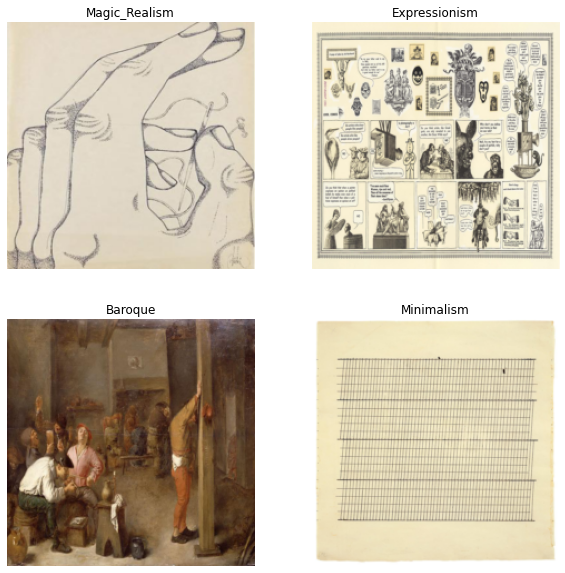

In [19]:
import matplotlib.pyplot as plt

def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

plt.figure(figsize=(10, 10))

for i in range(4):
    image, label = next(train_generator)
    image = image[0, :, :, :]
    index = np.argmax(label[0])
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(image)
    plt.title(get_class_string_from_index(index))
    plt.axis("off")

## 3. Load Efficientnet v2 model

Checkpoints available, both pretrained on normal imagenet and imagenet 21k:
 - 'efficientnetv2-s'
 - 'efficientnetv2-m'
 - 'efficientnetv2-l'
 - 'efficientnetv2-xl'
 - 'efficientnetv2-b0'
 - 'efficientnetv2-b1'
 - 'efficientnetv2-b2'
 - 'efficientnetv2-b3'

### Model initialization - only train last layers

They say they have this argument for whether to finetune the whole model (do_fine_tuning = True) or just the top layer (do_fine_tuning = False). I tried both. When I print out the model it says the same number of parameters is trainable though so Im not 100% sure there is any difference

In [6]:
import effnetv2_model
from keras.utils.layer_utils import count_params

In [12]:
#func to get model
def get_effnetv2(do_fine_tuning, model_name, weights = 'imagenet'):
    tf.keras.backend.clear_session()
    base_model = effnetv2_model.get_model(model_name, weights = weights, include_top=False)
    base_model.trainable = do_fine_tuning
    return base_model


#### Initialize model

In [19]:
#parameters
model_name = 'efficientnetv2-l' #@param {type:'string'}
do_fine_tuning = False
weights = 'imagenet21k'
image_size = 223

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    get_effnetv2(do_fine_tuning, model_name, weights = weights),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(25, activation='softmax'),
])
model.build((None, image_size, image_size, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (EffNetV2M  (None, 1280)             117746848 
 odel)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 25)                32025     
                                                                 
Total params: 117,778,873
Trainable params: 32,025
Non-trainable params: 117,746,848
_________________________________________________________________


In [35]:
import effnetv2_model
from keras.utils.layer_utils import count_params

def get_new_model():
    model_name = 'efficientnetv2-l' #@param {type:'string'}
    do_fine_tuning = False
    weights = 'imagenet21k'
    image_size = 223
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
        get_effnetv2(do_fine_tuning, model_name, weights = weights),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(25, activation='softmax'),
    ])
    model.build((None, image_size, image_size, 3))
    return model

## 4.Transfer Learning functions defined

### Training function

In [36]:
def train_effnetv2(model, train_generator, valid_generator, num_epochs, learning_rate, momentum = 0.9):
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum), 
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
      metrics=['accuracy'])
    
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    validation_steps = valid_generator.samples // valid_generator.batch_size
    
    hist = model.fit(train_generator, epochs = num_epochs, validation_data = valid_generator, steps_per_epoch=steps_per_epoch,\
                 validation_steps=validation_steps).history
    
    
    return model, hist
    

In [47]:
model, history = train_effnetv2(train_generator, valid_generator, num_epochs = 5, learning_rate = 0.005)

Num GPUs Available:  1
Epoch 1/5
62/62 [==============================] - 33s 230ms/step - loss: 13.3431 - accuracy: 0.1911 - val_loss: 14.3637 - val_accuracy: 0.2177
Epoch 2/5
62/62 [==============================] - 9s 144ms/step - loss: 11.8545 - accuracy: 0.4065 - val_loss: 19.5365 - val_accuracy: 0.2339
Epoch 3/5
62/62 [==============================] - 9s 145ms/step - loss: 12.7166 - accuracy: 0.4919 - val_loss: 25.3012 - val_accuracy: 0.2540
Epoch 4/5
62/62 [==============================] - 9s 139ms/step - loss: 13.8666 - accuracy: 0.4919 - val_loss: 23.1460 - val_accuracy: 0.2540
Epoch 5/5
62/62 [==============================] - 9s 147ms/step - loss: 13.0415 - accuracy: 0.5976 - val_loss: 26.8079 - val_accuracy: 0.2621


### Plot loss

In [37]:
def plot_training(hist):
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    import matplotlib.pyplot as plt

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='Training acc', color = 'orange')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

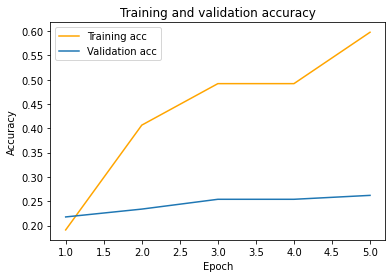

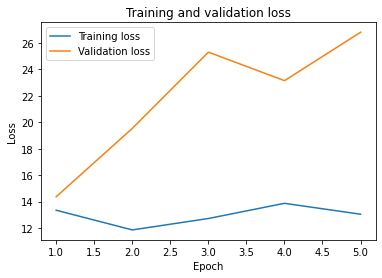

In [57]:
plot_training(history)

## 5. Hyperparameter tuning - grid search

In [38]:
def perform_hp_tuning(data_dir_train, data_dir_val, data_dir_test, lr_array, batchsize_array, num_epochs = 4):
    
    accuracies = np.empty([len(lr_array), len(batchsize_array)])
    print()
    print(print("---HP TESTING START--"))
    
    for j, batch_size in enumerate(batchsize_array):
        
        train_generator, valid_generator, test_generator = load_wikidata(data_dir_train, data_dir_val, data_dir_test,\
                                                                        batch_size = batch_size)
        for i, lr in enumerate(lr_array):
            print()
            print("LEARNING RATE", lr)
            print("BATCH SIZE", batch_size)
            
            model = get_new_model()
            
            model, hist = train_effnetv2(model,train_generator, valid_generator, num_epochs = num_epochs, learning_rate = lr)
            
            final_acc = hist['val_accuracy'][-1]
            accuracies[i,j] = final_acc
            
        
    print()
    print("---HP TESTING COMPLETE--")
    print("Accuracy matrix:")
    print(accuracies)
        
    best_lr_ind, best_bs_ind = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)
        
    optimal_lr = lr_array[best_lr_ind]
    optimal_batch_size = batchsize_array[best_bs_ind]
        
    print()
    print("Best learning rate: {}".format(optimal_lr))
    print("Best batch size: {}".format(optimal_batch_size))
        
    return optimal_lr, optimal_batch_size, accuracies
    

In [39]:
data_dir_train = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/wikipaintings_train'
data_dir_val = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/wikipaintings_val'
data_dir_test = '/projectnb/dl523/students/nannkat/EC520/wikipaintings_full/wikipaintings_test'

#lr_array = [0.6, 0.3, 0.01, 0.003, 0.001]
lr_array = [0.001]
# batch sizze 32- see screenshots
#batchsize_array = [64, 128, 256, 512]
batchsize_array = [512]
num_epochs = 1
optimal_lr, optimal_batch_size, accuracies = perform_hp_tuning(data_dir_train, data_dir_val, data_dir_test, lr_array, batchsize_array, num_epochs = num_epochs)


---HP TESTING START--
None
Loading data...

Found 7383 images belonging to 25 classes.
Found 66549 images belonging to 25 classes.
Found 8201 images belonging to 25 classes.
Label map:
{'Abstract_Art': 0, 'Abstract_Expressionism': 1, 'Art_Informel': 2, 'Art_Nouveau_(Modern)': 3, 'Baroque': 4, 'Color_Field_Painting': 5, 'Cubism': 6, 'Early_Renaissance': 7, 'Expressionism': 8, 'High_Renaissance': 9, 'Impressionism': 10, 'Magic_Realism': 11, 'Mannerism_(Late_Renaissance)': 12, 'Minimalism': 13, 'Naïve_Art_(Primitivism)': 14, 'Neoclassicism': 15, 'Northern_Renaissance': 16, 'Pop_Art': 17, 'Post-Impressionism': 18, 'Realism': 19, 'Rococo': 20, 'Romanticism': 21, 'Surrealism': 22, 'Symbolism': 23, 'Ukiyo-e': 24}

LEARNING RATE 0.001
BATCH SIZE 512
Num GPUs Available:  1
129/129 [==============================] - 1496s 11s/step - loss: 4.5231 - accuracy: 0.1481 - val_loss: 2.5765 - val_accuracy: 0.3302

---HP TESTING COMPLETE--
Accuracy matrix:
[[0.33021763]]

Best learning rate: 0.001
Best 

## 5. Test/display results

### Display example result - wikipaintings small

(4, 223, 223, 3)


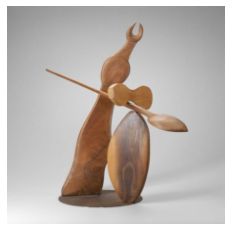

True label: Abstract_Art
Predicted label: Minimalism


In [84]:
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model1.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

### Display example result - wikipaintings full

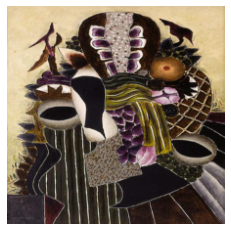

True label: Art_Informel
Predicted label: Surrealism


In [47]:
def get_class_string_from_index(index):
    for class_string, class_index in valid_generator.class_indices.items():
        if class_index == index:
            return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model2.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

### Evaluate

In [65]:
test_steps = test_generator.samples // test_generator.batch_size
model1.evaluate(test_generator, steps = test_steps)

62/62 [==============================] - 4s 58ms/step - loss: 3.1824 - accuracy: 0.1532


[3.182370901107788, 0.15322580933570862]

In [36]:
test_steps = test_generator.samples // test_generator.batch_size
model2.evaluate(test_generator, steps = test_steps)

256/256 [==============================] - 292s 1s/step - loss: 3.0195 - accuracy: 0.2994


[3.0194642543792725, 0.2994384765625]

In [61]:
test_steps = test_generator.samples // test_generator.batch_size
model2.evaluate(test_generator, steps = test_steps)

62/62 [==============================] - 9s 149ms/step - loss: 3.1869 - accuracy: 0.1210


[3.186856746673584, 0.12096773833036423]

### Predict

In [59]:
test_steps = test_generator.samples // test_generator.batch_size
preds = model.predict(test_generator, steps = test_steps)
print("predictions shape:", preds.shape)

predictions shape: (248, 25)


### Predict into .csv

In [108]:
preds = []
true_labels = []

In [109]:
for batch in range(len(test_generator)):
    images, labels = test_generator.next()
    #print('On batch no: {}'.format(i))
    for i in range(len(images)):
        image = images[i, :, :, :]
        label = np.argmax(labels[i])
        prediction_scores = model1.predict(np.expand_dims(image, axis=0))
        pred = np.argmax(prediction_scores)
        preds.append(pred)
        true_labels.append(label)
        

In [122]:
#check if it matches calculated accuracy
correct = 0
for i in range(len(preds)):
    if preds[i] == true_labels[i]:
        correct += 1

acc = correct/len(preds)
print(acc)

0.136


In [113]:
import pandas as pd
preds_df = pd.DataFrame(list(zip(preds, true_labels)),
               columns =['Prediction', 'True Label'])

In [114]:
preds_df.head()

,Prediction,True Label
0,2,0
1,0,0
2,13,0
3,0,0
4,5,0


In [118]:
preds_df.to_csv('/projectnb/dl523/students/nannkat/EC520/preds_vs_true_effnet.csv', index=False, header = False)

## 6. Appendix1 - Alternative way to read in image data

In [81]:
wikiart_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels = 'inferred',\
                                                                    label_mode = 'int', \
                                                                    batch_size = batch_size, image_size = (image_size, image_size),\
                                                                    shuffle = True, seed = 123
                                                                   )

wikiart_val = tf.keras.preprocessing.image_dataset_from_directory('/projectnb/dl523/students/nannkat/EC520/wikipaintings_val', labels = 'inferred',\
                                                                    label_mode = 'int', \
                                                                    batch_size = batch_size, image_size = (image_size, image_size),\
                                                                    shuffle = True, seed = 123, validation_split = 0.2,\
                                                                  subset = 'validation'
                                                                   )

Found 250 files belonging to 25 classes.
Found 250 files belonging to 25 classes.
Using 50 files for validation.


In [82]:
class_names = wikiart_train.class_names
print(class_names)
num_classes = len(wikiart_train.class_names)

['Abstract_Art', 'Abstract_Expressionism', 'Art_Informel', 'Art_Nouveau_(Modern)', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Early_Renaissance', 'Expressionism', 'High_Renaissance', 'Impressionism', 'Magic_Realism', 'Mannerism_(Late_Renaissance)', 'Minimalism', 'Naïve_Art_(Primitivism)', 'Neoclassicism', 'Northern_Renaissance', 'Pop_Art', 'Post-Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Surrealism', 'Symbolism', 'Ukiyo-e']


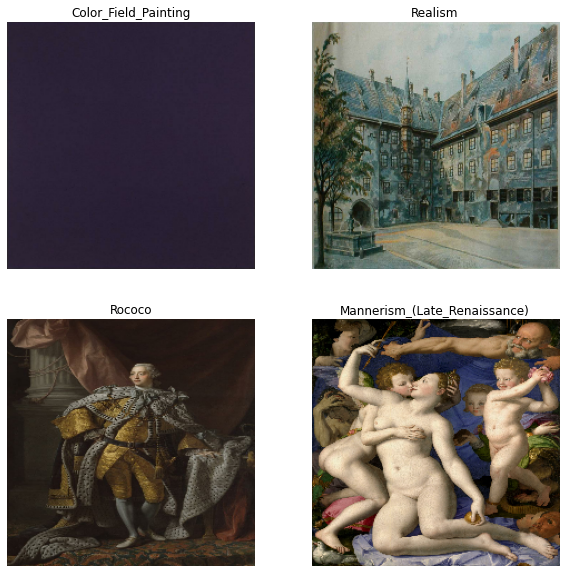

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in wikiart_train.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## 7. Appendix2 - Include fine tuning of model

### Create model

In [ ]:
#parameters
model_name = 'efficientnetv2-xl' #@param {type:'string'}
do_fine_tuning = True
weights = 'imagenet21k'
image_size = 223

In [ ]:
tf.keras.backend.clear_session()
model1 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[image_size, image_size, 3]),
    get_effnetv2(do_fine_tuning, model_name, weights = weigths),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax'),
])
model1.build((None, image_size, image_size, 3))
model1.summary()

### Train model

In [ ]:
model1.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model1.fit(train_generator, epochs = num_epochs, validation_data = valid_generator, steps_per_epoch=steps_per_epoch,\
                 validation_steps=validation_steps).history